In [1]:
# Progress bars
from tqdm import tqdm, trange

# Data-science
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

# Suppress FutureWarning messages
warnings.simplefilter(action='ignore', category=FutureWarning)

/opt/tljh/user/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Data Loading

We'll start with the results from the previous Tat/Stimulation experiment.
This dataframe encodes the effect size, p-value, and corrected p-value for each gene for each factor.

In [2]:
# Previous Results

analysis_df = pd.read_csv('/data/share/OMICS/wk14/effect_results.csv')
analysis_df.head()

,gene_name,Intercept_effect,timepoint[T.6X]_effect,Stim[T.Yes]_effect,Tat[T.Tat50]_effect,Tat[T.Tat250]_effect,timepoint[T.6X]:Stim[T.Yes]_effect,timepoint[T.6X]:Tat[T.Tat50]_effect,Stim[T.Yes]:Tat[T.Tat50]_effect,Intercept_pvalue,...,timepoint[T.6X]:Tat[T.Tat50]_pvalue,Stim[T.Yes]:Tat[T.Tat50]_pvalue,Intercept_pvalue_cor,timepoint[T.6X]_pvalue_cor,Stim[T.Yes]_pvalue_cor,Tat[T.Tat50]_pvalue_cor,Tat[T.Tat250]_pvalue_cor,timepoint[T.6X]:Stim[T.Yes]_pvalue_cor,timepoint[T.6X]:Tat[T.Tat50]_pvalue_cor,Stim[T.Yes]:Tat[T.Tat50]_pvalue_cor
0,TSPAN6,-1.223184,1.768997,1.241176,1.404311,1.325582,-2.332916,-0.600135,-1.850515,0.019108,...,0.531685,0.066247,0.460977,0.433026,0.970937,0.762863,0.857478,0.524022,1.0,0.879185
1,TNMD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000
2,DPM1,-1.010327,0.159270,2.127206,1.404194,0.446215,-1.549695,-0.106980,-1.778933,0.042894,...,0.908749,0.070697,0.701140,1.000000,0.219747,0.728464,1.000000,1.000000,1.0,0.909902
3,SCYL3,-0.182412,-0.074223,0.570243,1.202507,0.522238,-1.263662,-0.773773,-2.121090,0.749555,...,0.500788,0.077258,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,0.953444
4,FIRRM,-0.573036,0.814913,1.950613,0.364312,0.161759,-2.226752,-0.160514,-2.579715,0.283588,...,0.878450,0.023792,1.000000,1.000000,0.430251,1.000000,1.000000,0.732345,1.0,0.517083


In [3]:
list(analysis_df.columns)

['gene_name',
 'Intercept_effect',
 'timepoint[T.6X]_effect',
 'Stim[T.Yes]_effect',
 'Tat[T.Tat50]_effect',
 'Tat[T.Tat250]_effect',
 'timepoint[T.6X]:Stim[T.Yes]_effect',
 'timepoint[T.6X]:Tat[T.Tat50]_effect',
 'Stim[T.Yes]:Tat[T.Tat50]_effect',
 'Intercept_pvalue',
 'timepoint[T.6X]_pvalue',
 'Stim[T.Yes]_pvalue',
 'Tat[T.Tat50]_pvalue',
 'Tat[T.Tat250]_pvalue',
 'timepoint[T.6X]:Stim[T.Yes]_pvalue',
 'timepoint[T.6X]:Tat[T.Tat50]_pvalue',
 'Stim[T.Yes]:Tat[T.Tat50]_pvalue',
 'Intercept_pvalue_cor',
 'timepoint[T.6X]_pvalue_cor',
 'Stim[T.Yes]_pvalue_cor',
 'Tat[T.Tat50]_pvalue_cor',
 'Tat[T.Tat250]_pvalue_cor',
 'timepoint[T.6X]:Stim[T.Yes]_pvalue_cor',
 'timepoint[T.6X]:Tat[T.Tat50]_pvalue_cor',
 'Stim[T.Yes]:Tat[T.Tat50]_pvalue_cor']

## Gene Set Enrichemnt Analysis

In this strategy, we select a set of genes by some methodology.
In our case, that is "genes that significantly change expression in response to stimulation", but it can be _anything_.
Then, we compare our gene list to gene lists that have known functions ie "genes controled by TNF".
There will likely be some overlap between these two lists, we can use the hypergeomtric test to evaluate the likelihood of seeing this overlap by chance.
If the likelihood is low then we can say that gene that significantly change expression in response to stimulation are significantly enriched for TNF controled genes.

In [4]:
effect = 'Stim[T.Yes]'
p_value_cut = 0.01
effect_cut = 0.5

mask = (analysis_df[effect + '_pvalue_cor'] < p_value_cut) & (analysis_df[effect + '_effect'].abs() > effect_cut)
mask.sum()



762

Downloading and keeping up with gene lists updates is a time-consuming process.
So, there's an app for that.

https://maayanlab.cloud/Enrichr/

Check out the website.
You can copy-paste gene lists and do it using a GUI.
This is useful if you have a single list and only intend to do things once.
But, that's not very _pipeline-y_.

So, there's a library for that. GSEA-py.

https://gseapy.readthedocs.io/en/latest/introduction.html

They have a number of tools to automate gene-set enrichment analysis, including an API for Enrichr.

In [5]:
# Enrichment analysis
import gseapy as gp

In [6]:
bkg = list(analysis_df['gene_name'].dropna().unique()) # All genes in the set
gene_list = list(analysis_df['gene_name'][mask]) # Interesting genes
gene_list[:5]

['LASP1', 'CFLAR', 'AK2', 'FKBP4', 'HSPB6']

In [7]:
# Gene list Categories to Check
gene_sets = ['GO_Biological_Process_2023',
                'Chromosome_Location',
                'KEGG_2021_Human',
                'TRANSFAC_and_JASPAR_PWMs',
                'The_Kinase_Library_2023'
               ]

In [8]:
enr = gp.enrichr(gene_list=gene_list, # or "./tests/data/gene_list.txt",
                 gene_sets=gene_sets,
                 #background=bkg, # There's some error with setting background, skipping
                 organism='human', # don't forget to set organism
                 outdir=None, # don't write to disk
                 verbose=True
                )

2024-11-20 11:40:24,903 [INFO] Run: GO_Biological_Process_2023 
2024-11-20 11:40:26,328 [INFO] Run: Chromosome_Location 
2024-11-20 11:40:27,521 [INFO] Run: KEGG_2021_Human 
2024-11-20 11:40:28,518 [INFO] Run: TRANSFAC_and_JASPAR_PWMs 
2024-11-20 11:40:29,538 [INFO] Run: The_Kinase_Library_2023 
2024-11-20 11:40:30,535 [INFO] Done.


Results are just a DataFrame.

In [9]:
enr.results

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2023,Negative Regulation Of Cell Population Prolife...,37/379,1.747964e-07,0.000341,0,0,2.819730,43.873991,CDKN1A;CXCL8;PDCD5;AKR1B1;TNFAIP3;PTPRK;ETS1;T...
1,GO_Biological_Process_2023,Regulation Of Cell Communication (GO:0010646),12/49,2.163390e-07,0.000341,0,0,8.303135,127.423394,MTCH1;UGCG;NCLN;GRK5;VEPH1;SCG5;GLRX2;LRRC32;K...
2,GO_Biological_Process_2023,Regulation Of Cell Population Proliferation (G...,58/766,5.232853e-07,0.000545,0,0,2.156242,31.186027,CDKN1A;CSF2;CXCL8;PDCD5;AKR1B1;PTPRK;ETS1;IFIT...
3,GO_Biological_Process_2023,Negative Regulation Of Cellular Process (GO:00...,45/537,6.920636e-07,0.000545,0,0,2.391315,33.917433,CDA;CDKN1A;CXCL8;PDCD5;AKR1B1;ENO1;SPINT2;PTPR...
4,GO_Biological_Process_2023,Cellular Response To Lipopolysaccharide (GO:00...,17/124,4.790273e-06,0.003018,0,0,4.079872,49.974039,CXCL6;TGFB1;CXCL8;TNFAIP3;CXCL2;NFKB1;UXT;IL1A...
...,...,...,...,...,...,...,...,...,...,...
4252,The_Kinase_Library_2023,LATS1,20/802,9.857464e-01,0.992536,0,0,0.636146,0.009133,PPP1R15A;SLC22A4;SMIM13;WWTR1;PIANP;GCH1;PRAG1...
4253,The_Kinase_Library_2023,GRK6,16/672,9.858111e-01,0.992536,0,0,0.607533,0.008682,SLBP;POLR3GL;MTCL1;IRAG1;ARRB1;ACSL4;EIF2S2;GP...
4254,The_Kinase_Library_2023,GRK2,16/697,9.911246e-01,0.992536,0,0,0.584443,0.005210,CDV3;NFIX;POLR3GL;IRAG1;HMGA2;GPN1;IGF2R;NFKBI...
4255,The_Kinase_Library_2023,CDK6,17/732,9.913891e-01,0.992536,0,0,0.591150,0.005112,SLBP;ERRFI1;MYOCD;MTCL1;KIAA1671;MTUS2;HMGA2;N...


In [10]:
sig_mask = enr.results['Adjusted P-value'] < 0.01
enr.results.loc[sig_mask].head()

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2023,Negative Regulation Of Cell Population Prolife...,37/379,1.747964e-07,0.000341,0,0,2.819730,43.873991,CDKN1A;CXCL8;PDCD5;AKR1B1;TNFAIP3;PTPRK;ETS1;T...
1,GO_Biological_Process_2023,Regulation Of Cell Communication (GO:0010646),12/49,2.163390e-07,0.000341,0,0,8.303135,127.423394,MTCH1;UGCG;NCLN;GRK5;VEPH1;SCG5;GLRX2;LRRC32;K...
2,GO_Biological_Process_2023,Regulation Of Cell Population Proliferation (G...,58/766,5.232853e-07,0.000545,0,0,2.156242,31.186027,CDKN1A;CSF2;CXCL8;PDCD5;AKR1B1;PTPRK;ETS1;IFIT...
3,GO_Biological_Process_2023,Negative Regulation Of Cellular Process (GO:00...,45/537,6.920636e-07,0.000545,0,0,2.391315,33.917433,CDA;CDKN1A;CXCL8;PDCD5;AKR1B1;ENO1;SPINT2;PTPR...
4,GO_Biological_Process_2023,Cellular Response To Lipopolysaccharide (GO:00...,17/124,4.790273e-06,0.003018,0,0,4.079872,49.974039,CXCL6;TGFB1;CXCL8;TNFAIP3;CXCL2;NFKB1;UXT;IL1A...


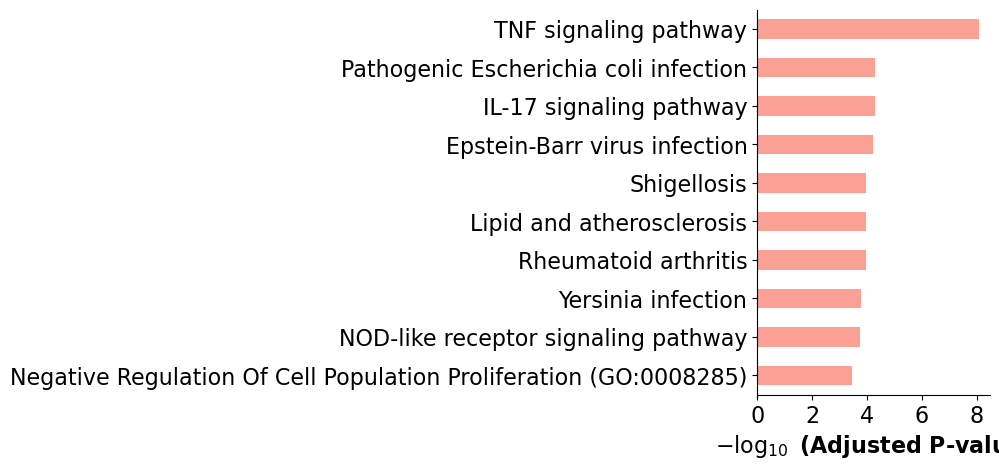

In [11]:
ax = gp.barplot(enr.results,
              column="Adjusted P-value",
              size=5,
              top_term=10,
              figsize=(3,5),
              )


In [12]:
enrichr_cats = ['GO_Biological_Process_2023',
                'Chromosome_Location',
                'KEGG_2021_Human',
                'TRANSFAC_and_JASPAR_PWMs',
                'The_Kinase_Library_2023'
               ]

def get_effect_names(columns):
    return sorted(set(col.split('_')[0] for col in columns))

def do_enricher(mask, bkg, gene_sets):

    try:
        enr = gp.enrichr(gene_list=list(analysis_df.loc[mask, 'gene_name']),
                         gene_sets=gene_sets,
                         #background=bkg,
                         organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
                         outdir=None, # don't write to disk
                         verbose=False
                    )
    except KeyboardInterrupt:
        raise
    except:
        print('Server failed. Trying Again')
        return do_enricher(mask, bkg, gene_sets)
    
    return enr.results


def describe_enrichr(results, pvalue=0.01):
    
    mask = results['Adjusted P-value']<pvalue
    for st, terms in results[mask].groupby('Gene_set'):
        print(f'{st}')
        print(f'Significant terms:', len(terms.index))
        print(f'{"Overlap":15}{"Adjusted P":15}Term')
        for _, term in terms.sort_values('Odds Ratio', ascending=False).head(10).iterrows():
            odds = term['Overlap']
            adjp = term['Adjusted P-value']
            name = term['Term']
            print(f'{f"{odds}":15}{f"{adjp:0.3e}":15}{name}')
        print() 

def describe_gene_list(gene_list):
    print('Too few gene for Enrichment Analysis')
    print(f'{"Gene":20}{effect}')
    print(gene_list)

In [13]:
# 
# Make an empty list to start
all_res = []

for effect in get_effect_names(analysis_df.columns):
    if not ((effect == 'Intercept') | effect.startswith('donor') | (effect == 'gene')):
        print('Checking:', effect)

        mask = (analysis_df[effect + '_pvalue_cor'] < 0.01) & (analysis_df[effect + '_effect'].abs() > 0.5)
        print('Significant Genes (p<0.01 after BH-correction):', mask.sum())

        if mask.sum() < 10:
            effect_key = effect+'_effect'
            describe_gene_list(analysis_df.loc[mask, ['gene_name', effect_key]])
        else:
            enrich_res = do_enricher(mask, None, enrichr_cats)
            describe_enrichr(enrich_res)
            
            all_res.append(enrich_res.copy())
            all_res[-1]['effect'] = effect
            
            #enrich_res.to_csv(f'GSEA_{effect}.csv')

        print()
        print()
        
all_res_df = pd.concat(all_res, axis=0, ignore_index=True)
all_res_df.head()

Checking: Stim[T.Yes]
Significant Genes (p<0.01 after BH-correction): 762
GO_Biological_Process_2023
Significant terms: 12
Overlap        Adjusted P     Term
12/49          3.407e-04      Regulation Of Cell Communication (GO:0010646)
9/44           9.057e-03      Positive Regulation Of Nucleocytoplasmic Transport (GO:0046824)
17/124         3.018e-03      Cellular Response To Lipopolysaccharide (GO:0071222)
16/117         3.672e-03      Cellular Response To Molecule Of Bacterial Origin (GO:0071219)
19/159         3.672e-03      Response To Lipopolysaccharide (GO:0032496)
24/232         3.672e-03      Regulation Of I-kappaB kinase/NF-kappaB Signaling (GO:0043122)
24/236         4.012e-03      Inflammatory Response (GO:0006954)
27/272         3.076e-03      Positive Regulation Of Cell Migration (GO:0030335)
37/379         3.407e-04      Negative Regulation Of Cell Population Proliferation (GO:0008285)
45/537         5.450e-04      Negative Regulation Of Cellular Process (GO:0048523)

KEG

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,effect
0,GO_Biological_Process_2023,Negative Regulation Of Cell Population Prolife...,37/379,1.747964e-07,0.000341,0,0,2.819730,43.873991,CDKN1A;CXCL8;PDCD5;AKR1B1;TNFAIP3;PTPRK;ETS1;T...,Stim[T.Yes]
1,GO_Biological_Process_2023,Regulation Of Cell Communication (GO:0010646),12/49,2.163390e-07,0.000341,0,0,8.303135,127.423394,MTCH1;UGCG;NCLN;GRK5;VEPH1;SCG5;GLRX2;LRRC32;K...,Stim[T.Yes]
2,GO_Biological_Process_2023,Regulation Of Cell Population Proliferation (G...,58/766,5.232853e-07,0.000545,0,0,2.156242,31.186027,CDKN1A;CSF2;CXCL8;PDCD5;AKR1B1;PTPRK;ETS1;IFIT...,Stim[T.Yes]
3,GO_Biological_Process_2023,Negative Regulation Of Cellular Process (GO:00...,45/537,6.920636e-07,0.000545,0,0,2.391315,33.917433,CDA;CDKN1A;CXCL8;PDCD5;AKR1B1;ENO1;SPINT2;PTPR...,Stim[T.Yes]
4,GO_Biological_Process_2023,Cellular Response To Lipopolysaccharide (GO:00...,17/124,4.790273e-06,0.003018,0,0,4.079872,49.974039,CXCL6;TGFB1;CXCL8;TNFAIP3;CXCL2;NFKB1;UXT;IL1A...,Stim[T.Yes]


<AxesSubplot: xlabel='effect'>

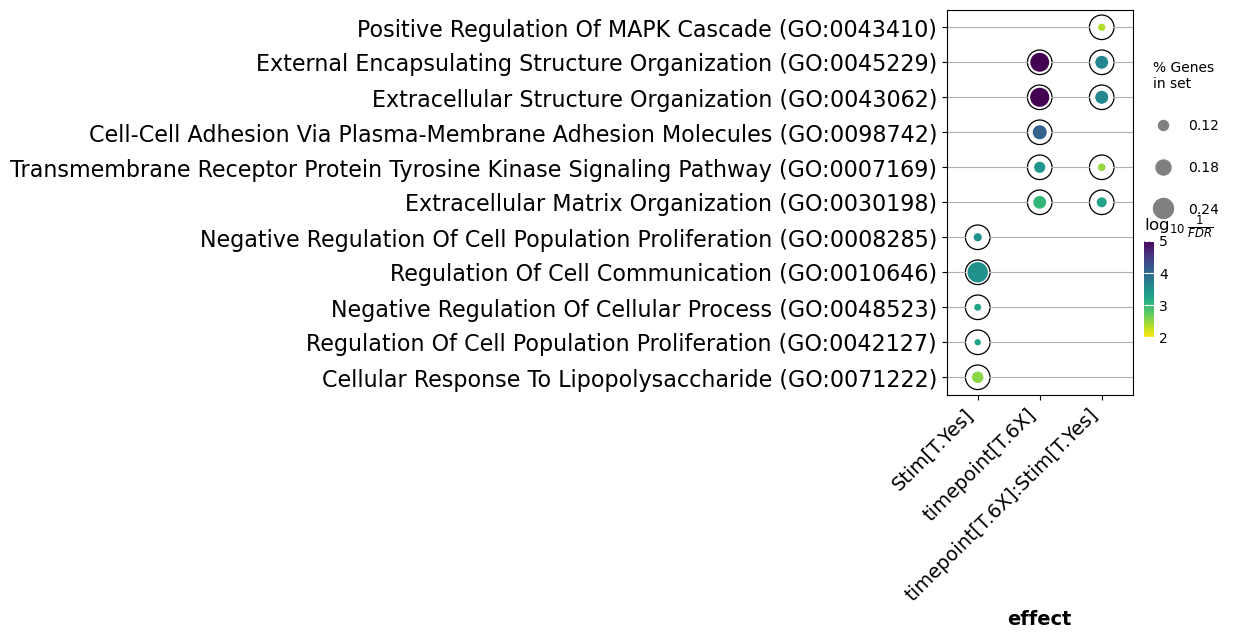

In [14]:
gp.dotplot(all_res_df.query('Gene_set == "GO_Biological_Process_2023"'),
              column="Adjusted P-value",
              x='effect', # set x axis, so you could do a multi-sample/library comparsion
              size=10,
              top_term=5,
              figsize=(3,5),
              xticklabels_rot=45, # rotate xtick labels
              show_ring=True, # set to False to revmove outer ring
              marker='o',
             )